## Reload the `EC_estimator.py` code to consider any changes

In [51]:
#reload model magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import EC_estimator as annec

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

: 

## Load the dataset, preprocessing, and apply ANN model

In [115]:
block_data = True


# Except for X2, the inputs that have a "2" in their name have the DCC data transformed
# from # days operating to 1s and 0s representing the days
# For train versus test see the next cell and the variables "train_rows" and "test_rows". 
# The 


loc = "x2"
ntest = 9039 # First ntest are the testing data, rest of history is used for training. Originall ntest=6039

if loc not in ["x2","rs","jp","emm"]: raise ValueError("Input location not recognized")


# X2 requires more epochs
if loc == "x2":
    input_csv ='Inputs/x2_data_in.csv'
    ec_col = "x2"
    model_save_path = r'./Export/x2'
    nepoch=2000
elif loc == "rs":
    input_csv ='Inputs/inputs_rs2.csv'
    ec_col = "rsl_ec"
    model_save_path = r'./Export/rock_slough'
    nepoch=150
elif loc == "jp":
    # Jersey Point requires more epochs
    input_csv ='Inputs/inputs_jp2.csv'
    ec_col = "jer_ec"
    model_save_path = r'./Export/jersey_point'
    nepoch=100
elif loc == "emm":
    input_csv ='Inputs/inputs_emm2.csv'
    ec_col = "emm_ec"
    model_save_path = r'./Export/emmaton'
    nepoch = 200


ndims = {"ndoi" : 18, 
         "smscg" : 18, 
         "tide" : 18 } if  loc == "x2" else {
                    "sac" : 18, 
                    "exports" : 18, 
                    "dcc": 18, 
                    "net_dcd" : 18, 
                    "sjr": 18, 
                    "tide" : 18, 
                    "smscg" : 18} 
annec.set_num_feature_dims(ndims)
print("input_csv=",input_csv,"nepoch=",nepoch)

df = annec.load_data(input_csv)
df = pd.read_csv(input_csv,index_col=0,header=0,sep=",")
blocked = pd.concat([annec.block_history(df[x]) for x in df.columns],axis=1)
df_var = blocked


if loc=="x2":
    dfout = pd.read_csv("Inputs/x2_data_out.csv",index_col=0)
    dfout.index.name="date"
    df_var[("EC","0d")] = dfout
    THRESH  = 60000.
    df_var = df_var.loc[df_var.loc[:,('ndoi','0d')]<THRESH]
else:
    df_var[("EC","0d")] = df.EC
    THRESH = 40000.
    df_var = df_var.loc[df_var.loc[:,('sac','0d')]<THRESH]
df_var.index.name="date"
df_var = df_var.loc[~df_var.isnull().any(axis=1)]
print(df_var)
annec.calc_lags_feature(df_var)


input_csv= Inputs/x2_data_in.csv nepoch= 8
Index(['Unnamed: 0', 'ndoi', 'smscg', 'tide'], dtype='object')
var               ndoi                                                      \
lag                 0d           1d           2d           3d           4d   
date                                                                         
4/28/1923  25756.02603  26077.05891  26381.61118  26668.08156  26934.86878   
4/29/1923  25420.11384  25756.02603  26077.05891  26381.61118  26668.08156   
4/30/1923  25070.92359  25420.11384  25756.02603  26077.05891  26381.61118   
5/1/1923   24710.05658  25070.92359  25420.11384  25756.02603  26077.05891   
5/2/1923   24339.11409  24710.05658  25070.92359  25420.11384  25756.02603   
...                ...          ...          ...          ...          ...   
9/26/2015   3000.00000   3000.00000   3000.00000   3000.00000   3000.00000   
9/27/2015   3000.00000   3000.00000   3000.00000   3000.00000   3000.00000   
9/28/2015   3000.00000   3000.00000 

## Preprocess and train

In [121]:
annec.calc_lags_feature(df_var)  # Redundant call to make sure this is calculated

# Split data
train_rows = df_var.shape[0] - ntest
print("# of test rows (at head)",ntest,"# of train rows (at tail)",train_rows,)
df_train, df_test = annec.split_data(df_var, train_rows, ntest)

# Build model inputs
inputs = annec.build_model_inputs(df_var)

# Preprocessing layers
layers = annec.preprocessing_layers(df_var, inputs, thresh=THRESH)

# Build model
neurons = [8, 2, 1]  # This is an example; adapt it to your needs
activations = ['sigmoid', 'sigmoid']
model, tensorboard_cb = annec.build_model(layers, inputs)

X_train = {feature: df_train.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()}

y_train = df_train[('EC','0d')].to_frame()  # situation where one column is produced and coerced to a series
# Otherwise you would do something like:
#y.droplevel(level='lag',axis=1).rename(mapper={"EC":"ec_col})
y_train.columns = [ec_col]



X_test = {feature: df_test.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()}


y_test = df_test[('EC','0d')].to_frame()  # Only works for univariate dataset where it is a series
y_test.columns = [ec_col] 



# Train model
print(f"nepoch={nepoch}")
history, model = annec.train_model(model, tensorboard_cb, X_train, y_train, X_test, y_test,nepoch=nepoch)

NameError: name 'num_feature_dims' is not defined

## Illustration of by-variable input (df_var)

In [124]:

df = annec.load_data(input_csv)
ndims = {"ndoi" : 18, 
         "smscg" : 18, 
         "tide" : 18 } if  loc == "x2" else {
                    "sac" : 18, 
                    "exports" : 18, 
                    "dcc": 18, 
                    "net_dcd" : 18, 
                    "sjr": 18, 
                    "tide" : 18, 
                    "smscg" : 18} 
annec.set_num_feature_dims(ndims)
# This will break up the incoming DataFrame into a MultiIndex column
# with the site/variable (e.g. Sac) as the 0-level index and
# lag (e.g. '3d') as the fast index.
print(df)
df_var = annec.df_by_variable(df)


# This is an illustration of how to extract a single location/variable
# so that it (with its lags) can be used as a single input in the ANN. 
# In the traditional CalSIM model would be 18 values 
# The droplevel gets rid of the vestiges of the multiindex

dcc = df_var.loc[:, pd.IndexSlice['tide',:]].droplevel(level="var",axis=1)






            date         ndoi  smscg    tide
0       1/1/1923  29116.34118      1  6.8438
1       1/2/1923  28944.86599      1  7.2815
2       1/3/1923  28767.85217      1  7.4221
3       1/4/1923  28585.80518      1  7.2782
4       1/5/1923  28399.23053      1  6.9075
...          ...          ...    ...     ...
33871  9/26/2015   3000.00000      0  6.2435
33872  9/27/2015   3000.00000      0  6.1302
33873  9/28/2015   3000.00000      0  6.2436
33874  9/29/2015   3000.00000      0  6.7243
33875  9/30/2015   3000.00000      0  6.7900

[33876 rows x 4 columns]


## Evaluation of the model

In [125]:
# Calculate metrics for ANN
#print(model.summary())
metrics = []
_ = [print(x) for x in X_test.keys()]

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("predictions")
print(y_train_pred[-4:-1])
print(y_test_pred[-4:-1])
print("input data")
#print(X_train["sac"].iloc[-4:-1])
#print(X_test["sac"].iloc[-4:-1])
print("end predictions")
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)

#print(tabulate(df3, headers='keys', tablefmt='psql'))



ndoi
smscg
tide
predictions
[[13.365437]
 [13.36591 ]
 [13.366856]]
[[13.322544]
 [13.320944]
 [13.330263]]
input data
end predictions


8


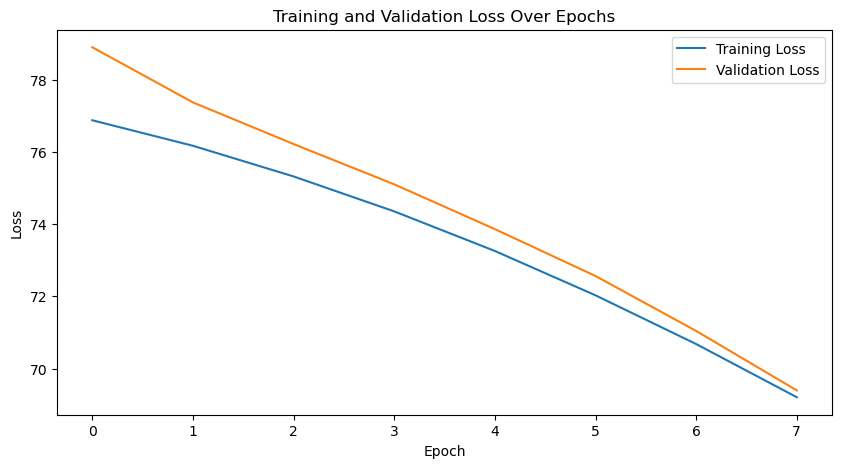

In [126]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

0    389.398041
Name: 1942-11-18, dtype: float32


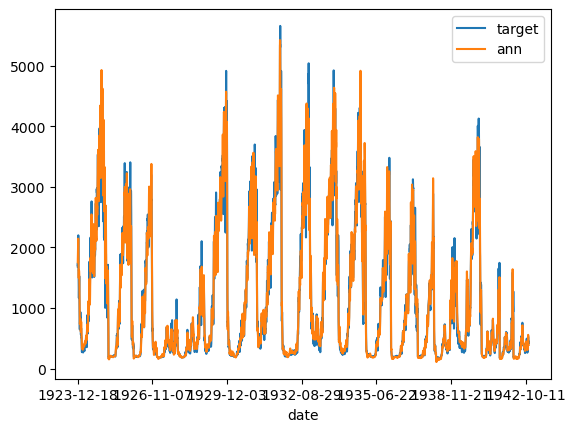

In [66]:
import matplotlib.pyplot as plt
ax = y_test.plot()
pred = pd.DataFrame(index=y_test.index,data= y_test_pred)
print(pred.iloc[-1])
pred.plot(ax=ax)
plt.legend(["target","ann"])

## Save the final model

In [67]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

#saved_model_cli show --dir ".\ANN_Models3" --tag_set serve --signature_def "serving_default“

print(f"Saving model at {pd.Timestamp.now()} at {model_save_path}")
annec.save_model(model, model_save_path)

Saving model at 2024-09-19 23:22:25.157835 at ./Export/emmaton


INFO:tensorflow:Assets written to: ./Export/emmaton\assets


INFO:tensorflow:Assets written to: ./Export/emmaton\assets


Model saved at location: ./Export/emmaton


dd

In [68]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for ANN
metrics = []
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))


+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |       0.99 |       107.71 |                    1.01 |      0.98 |      169.98 |                   2.87 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for 

df_sample = pd.read_csv("F:/projects/ann_calsim_ec_estimator/Inputs/selected.csv", header=None)
input_sample = [frame.to_frame().to_numpy().transpose() for ndx,frame in df_sample.iterrows()] 
print("Sample")
print(input_sample)
y_sample_pred = loaded_model.predict(input_sample)
print(y_sample_pred)





FileNotFoundError: [Errno 2] No such file or directory: 'F:/projects/ann_calsim_ec_estimator/Inputs/selected.csv'